# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Classification instead of regression
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [3]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [4]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"

def classify_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        if (m1 in seq and m2 in seq):
            print("both motifs in seq - skipping")
            c = 'skip'
        elif m1 in seq:
            c = 2
        elif m2 in seq:
            c = 1
        else:
            c = 0
        data.append([locus_tag,c])
        
    df = pd.DataFrame(data, columns=['locus_tag','reg'])
    return df

In [5]:
syn_motif_dict = dict(classify_seqs_motif(XYdf[['locus_tag','upstream_region']].values).values)
syn_motif_dict

both motifs in seq - skipping
both motifs in seq - skipping


{'EQU24_RS00005': 0,
 'EQU24_RS00010': 0,
 'EQU24_RS00015': 0,
 'EQU24_RS00025': 0,
 'EQU24_RS00060': 0,
 'EQU24_RS00065': 0,
 'EQU24_RS00080': 0,
 'EQU24_RS00085': 0,
 'EQU24_RS00105': 0,
 'EQU24_RS00110': 0,
 'EQU24_RS00125': 0,
 'EQU24_RS00165': 0,
 'EQU24_RS00175': 0,
 'EQU24_RS00180': 0,
 'EQU24_RS00185': 0,
 'EQU24_RS00195': 0,
 'EQU24_RS00200': 0,
 'EQU24_RS00205': 0,
 'EQU24_RS00210': 0,
 'EQU24_RS00215': 0,
 'EQU24_RS00225': 0,
 'EQU24_RS00230': 0,
 'EQU24_RS00245': 0,
 'EQU24_RS00250': 0,
 'EQU24_RS00255': 0,
 'EQU24_RS00260': 0,
 'EQU24_RS00265': 0,
 'EQU24_RS00270': 0,
 'EQU24_RS00275': 1,
 'EQU24_RS00295': 0,
 'EQU24_RS00300': 0,
 'EQU24_RS00315': 0,
 'EQU24_RS00320': 0,
 'EQU24_RS00330': 0,
 'EQU24_RS00370': 0,
 'EQU24_RS00385': 0,
 'EQU24_RS00390': 0,
 'EQU24_RS00400': 0,
 'EQU24_RS00405': 0,
 'EQU24_RS00425': 0,
 'EQU24_RS00455': 0,
 'EQU24_RS00470': 0,
 'EQU24_RS00475': 0,
 'EQU24_RS00480': 0,
 'EQU24_RS00490': 0,
 'EQU24_RS00495': 0,
 'EQU24_RS00500': 0,
 'EQU24_RS005

In [6]:
XYdf['reg'] = XYdf['locus_tag'].apply(lambda x: syn_motif_dict[x])
XYdf = XYdf[XYdf['reg'] != 'skip']
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,reg
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,0
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,0
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,0
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,0
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,0
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,0
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,0
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,0


In [7]:
loc2seq = dict([(x,z) for (x,z) in XYdf[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x='reg', y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()

## Load 5G seqs into data loaders

In [9]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [10]:
full_train_df,test_df = tu.quick_split(XYdf)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='reg',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [11]:
def see_batch_class_dist(train_dl):
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in [0,1,2]:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()
    
    
    

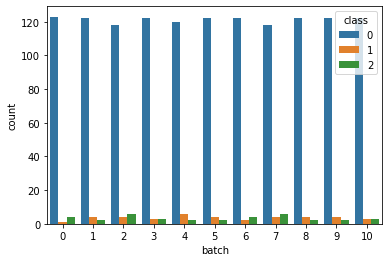

In [12]:
see_batch_class_dist(ohe_train_dl)

In [13]:
from torch.utils.data.sampler import WeightedRandomSampler


In [14]:
# retry making dataloader with weighted sampler
class_sample_count = train_df['reg'].value_counts().values
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_df['reg'].values])
samples_weight = torch.from_numpy(samples_weight).double()


sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
sampler

In [15]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='reg',
    sampler=sampler,
    shuffle=False
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [16]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1761, 17)
(441, 17)
(1408, 18)
(353, 18)


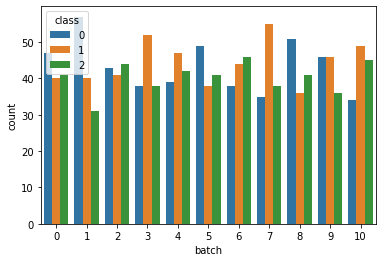

In [17]:
see_batch_class_dist(ohe_train_dl)

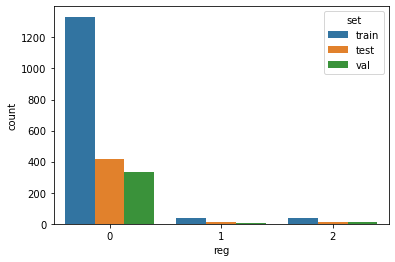

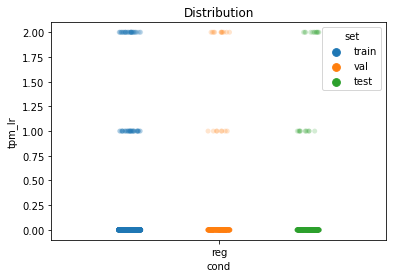

In [18]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='reg')
view_train_test_dist(train_df, test_df,["reg"],val_df=val_df)

In [19]:
seqs = train_df['upstream_region'].values

print("CACACA:",len([x for x in seqs if m1 in x]))
print("GTGTGT:",len([x for x in seqs if m2 in x]))

print("NO CACACA:",len([x for x in seqs if m1 not in x]))
print("NO GTGTGT:",len([x for x in seqs if m2 not in x]))

print("BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
print("NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))

CACACA: 36
GTGTGT: 39
NO CACACA: 1372
NO GTGTGT: 1369
BOTH: 0
NEITHER: 1333


## Non-optuna training

In [20]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    #loss_func = torch.nn.MSELoss() 
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [21]:
cel = nn.CrossEntropyLoss()

In [22]:
a = torch.tensor([[1.0, 2.2, 0.1],[0.3,1.0,0.1]])
b = torch.tensor([2,2])
cel(a,b)

tensor(1.9984)

In [23]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [24]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [25]:
# def parity_plot_multi(model,df, pearson):
#     #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
#     sns.scatterplot(data=df,y='pred',x='truth',hue='task',alpha=0.2)
#     #draw y=x line
#     xpoints = ypoints = plt.xlim()
#     plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False)

#     plt.ylim(xpoints)
#     plt.ylabel("Predicted Score",fontsize=14)
#     plt.xlabel("Actual Score",fontsize=14)
#     plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    
#     plt.show()

# def alt_parity_plot_multi(model,df, pearson,task):
#     '''
#     Make an interactive parity plot with altair
#     '''
#     chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
#         alt.Y('pred:Q'),
#         alt.X('truth:Q'),
#         tooltip=['seq:N']
#     ).properties(
#         title=f'Model (pearson:{pearson})'
#     ).interactive()
    
#     chart.save(f'alt_out/parity_plot_{task}_{model}.html')
    
    
def parity_pred_multi(models, genes, oracle,task,objs,alt=True,syn_data=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: (pearson corr, parity_df)
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.item() for x in model(s.float())]

            for i in range(len(preds)):
                data.append((gene,actual[i], preds[i],objs[i],dna))

        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','task','seq'])
        pearson = df['truth'].corr(df['pred'])
        
        if not syn_data: # if using real genes, add real gene info
            df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
            df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])
            df['type'] = df['locus_tag'].apply(lambda x: locus2info[x]['type'])
        
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
        parity_plot_multi(model_name, df, pearson)

    return dfs


        
            
            

In [26]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        
        dfs[model_name] = (c,df)
        
    return dfs

In [27]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 100,
                 fc_node_num1 = 100
                ):
        super().__init__()
        
        self.seq_len = seq_len
        #self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1


        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            # Fully connected layer 0
            nn.Linear(fc_node_num0, fc_node_num1),
            nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num1, 3),
            nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

### Deep linear

In [28]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# try with this? 

here
made it
0 1.1020820704803251
1 1.102627063270331
2 1.1022264386709284
3 1.1023365039663342
4 1.1024128630883971
5 1.1019284900794961
6 1.101706600391831
7 1.1022998999603748
8 1.1021215517189955
9 1.102562632168994
10 1.1023645725196212
11 1.1034874348735
12 1.1036974623925964
13 1.1034376594230069
14 1.1033968641805243
15 1.1032494958331835
16 1.103400983823933
17 1.103777798984949
18 1.1029623878576262
19 1.103251917166345
20 1.103316557981475
21 1.1036673807895216
22 1.1045226233539096
23 1.104662146851969
24 1.1048604574149459
25 1.1053079690879195
26 1.1057996260208043
27 1.1064562611809534
28 1.1068884434848603
29 1.106970586452538
30 1.1074122642997979
31 1.1084372875710722
32 1.109133857167814
33 1.1097539332365516
34 1.1107742124508866
35 1.1104757620322467
36 1.1114895441714494
37 1.1117959036030107
38 1.112753605707509
39 1.1136085632502526
40 1.11408426640054
41 1.1156807178816106
42 1.1159098317197633
43 1.1169397503390865
44 1.1178046090069302
45 1.1187534588929953
4

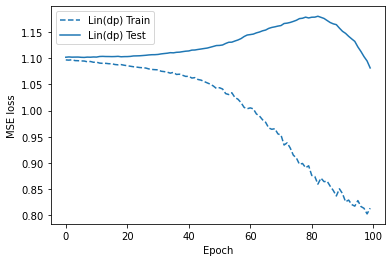

In [29]:
seq_len = len(train_df['upstream_region'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
print("here")
mer8motif_model_lin_d.to(DEVICE)

print("made it")
mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    lr=0.01,
    epochs=100
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]

tu.quick_loss_plot(mer8motif_lin_d_data_label)

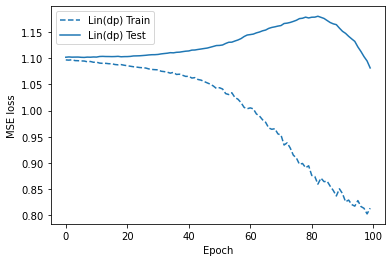

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [30]:
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [31]:
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    fc_node_num0=100,
    fc_node_num1=100
)
mer8motif_model_cnn.to(DEVICE)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    lr=0.01,
    epochs=100,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]


0 1.1188476014745135
1 1.118744556694463
2 1.1188846211933212
3 1.118933477752945
4 1.118724129017622
5 1.1185967550736986
6 1.1182544970985175
7 1.11832718437184
8 1.1183801696928635
9 1.118133059979836
10 1.1183391873627142
11 1.1185731512966641
12 1.1183237029878006
13 1.118263560381557
14 1.1189326976581606
15 1.1191827281676339
16 1.1192475033887048
17 1.1189832545542515
18 1.1188281264588786
19 1.1188653903372228
20 1.118594327324173
21 1.1184141720320617
22 1.1181982630710763
23 1.1179395525718883
24 1.117722246532062
25 1.1178773850962394
26 1.1176921291324302
27 1.1176109175506461
28 1.117564911207464
29 1.117195001404954
30 1.1170869525363696
31 1.116875140592667
32 1.1166535170152572
33 1.1165203372749999
34 1.1167826004136385
35 1.1168543657567616
36 1.1170035948496702
37 1.1167266122342507
38 1.1167261556592947
39 1.116779104508354
40 1.1165192336603873
41 1.1166176718287697
42 1.1168265994479907
43 1.1166472303293244
44 1.1164375503069957
45 1.1160863023304062
46 1.115420

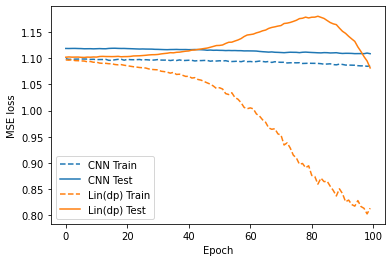

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9152, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=3, bias=True)
    (10): Softmax(dim=1)
  )
)

In [32]:
tu.quick_loss_plot(mer8motif_cnn_data_label+mer8motif_lin_d_data_label)

mer8motif_model_cnn

In [33]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]

seqs = train_df['locus_tag'].values #val_df['locus_tag'].values
task = "6mer_motif"

plot_confusion(models, )

TypeError: plot_confusion() missing 3 required positional arguments: 'genes', 'oracle', and 'objs'

Running LinearDeep
Running CNN


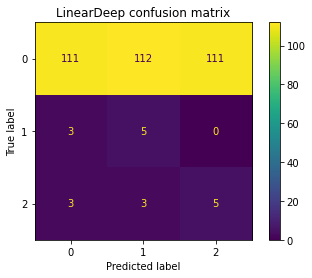

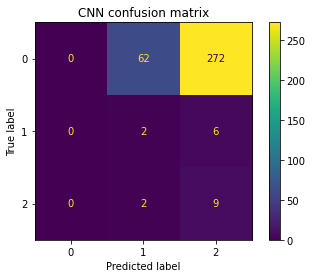

In [39]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


seqs = val_df['locus_tag'].values#train_df['locus_tag'].values #val_df['locus_tag'].values
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','reg']].values])


dfs = plot_confusion(models, seqs, oracle_syn,[task])

In [40]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

In [41]:
cnn_res = dfs['CNN'][1]
lind_res = dfs['LinearDeep'][1]

In [42]:
def cls_report(df,model_name):
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f})")
    for a in ['micro','macro','weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")


In [43]:
cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.343)
micro: p=0.343	 r=0.343	 f1=0.343
macro: p=0.344	 r=0.471	 f1=0.216
weighted: p=0.900	 r=0.343	 f1=0.470

CNN (acc=0.031)
micro: p=0.031	 r=0.031	 f1=0.031
macro: p=0.021	 r=0.356	 f1=0.038
weighted: p=0.002	 r=0.031	 f1=0.003


In [44]:
def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        prob,cls = model(s.float()).topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            print(f"{gene}: pred:{cls.item()} actual:{actual}")

In [45]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS00010: pred:2 actual:0
EQU24_RS00015: pred:1 actual:0
EQU24_RS00060: pred:2 actual:0
EQU24_RS00080: pred:2 actual:0
EQU24_RS00085: pred:2 actual:0
EQU24_RS00110: pred:2 actual:0
EQU24_RS00125: pred:2 actual:0
EQU24_RS00165: pred:2 actual:0
EQU24_RS00180: pred:2 actual:0
EQU24_RS00195: pred:1 actual:0
EQU24_RS00205: pred:2 actual:0
EQU24_RS00210: pred:1 actual:0
EQU24_RS00215: pred:2 actual:0
EQU24_RS00225: pred:2 actual:0
EQU24_RS00230: pred:1 actual:0
EQU24_RS00245: pred:2 actual:0
EQU24_RS00255: pred:2 actual:0
EQU24_RS00260: pred:2 actual:0
EQU24_RS00265: pred:2 actual:0
EQU24_RS00275: pred:2 actual:1
EQU24_RS00315: pred:2 actual:0
EQU24_RS00320: pred:2 actual:0
EQU24_RS00370: pred:2 actual:0
EQU24_RS00400: pred:2 actual:0
EQU24_RS00425: pred:2 actual:0
EQU24_RS00455: pred:2 actual:0
EQU24_RS00470: pred:2 actual:0
EQU24_RS00490: pred:2 actual:0
EQU24_RS00495: pred:2 actual:0
EQU24_RS00500: pred:2 actual:0
EQU24_RS00560: pred:2 actual:0
EQU24_RS00595: pred:2 actual:0
EQU24_RS

EQU24_RS05730: pred:2 actual:0
EQU24_RS05735: pred:2 actual:0
EQU24_RS05745: pred:2 actual:0
EQU24_RS05770: pred:1 actual:0
EQU24_RS05780: pred:2 actual:0
EQU24_RS05790: pred:1 actual:0
EQU24_RS05820: pred:2 actual:0
EQU24_RS05825: pred:2 actual:0
EQU24_RS05830: pred:2 actual:0
EQU24_RS05835: pred:2 actual:0
EQU24_RS05850: pred:2 actual:0
EQU24_RS05855: pred:2 actual:0
EQU24_RS05860: pred:2 actual:0
EQU24_RS05865: pred:2 actual:0
EQU24_RS05870: pred:2 actual:0
EQU24_RS05880: pred:2 actual:0
EQU24_RS05905: pred:2 actual:0
EQU24_RS05920: pred:2 actual:0
EQU24_RS05925: pred:2 actual:0
EQU24_RS05930: pred:2 actual:0
EQU24_RS05940: pred:2 actual:0
EQU24_RS05960: pred:2 actual:0
EQU24_RS06005: pred:2 actual:0
EQU24_RS06010: pred:2 actual:0
EQU24_RS06045: pred:2 actual:0
EQU24_RS06070: pred:2 actual:0
EQU24_RS06095: pred:2 actual:0
EQU24_RS06100: pred:2 actual:0
EQU24_RS06115: pred:1 actual:0
EQU24_RS06140: pred:2 actual:0
EQU24_RS06145: pred:2 actual:0
EQU24_RS06150: pred:1 actual:0
EQU24_RS

EQU24_RS11380: pred:2 actual:0
EQU24_RS11385: pred:2 actual:0
EQU24_RS11390: pred:2 actual:0
EQU24_RS11415: pred:1 actual:0
EQU24_RS11420: pred:2 actual:0
EQU24_RS11440: pred:2 actual:0
EQU24_RS11455: pred:2 actual:0
EQU24_RS11470: pred:2 actual:0
EQU24_RS11475: pred:2 actual:0
EQU24_RS11480: pred:2 actual:0
EQU24_RS11490: pred:2 actual:0
EQU24_RS11495: pred:2 actual:0
EQU24_RS11500: pred:2 actual:0
EQU24_RS11515: pred:2 actual:0
EQU24_RS11540: pred:2 actual:0
EQU24_RS11555: pred:2 actual:0
EQU24_RS11560: pred:2 actual:0
EQU24_RS11575: pred:1 actual:0
EQU24_RS11595: pred:2 actual:0
EQU24_RS11600: pred:1 actual:0
EQU24_RS11630: pred:1 actual:0
EQU24_RS11635: pred:2 actual:0
EQU24_RS11645: pred:2 actual:0
EQU24_RS11650: pred:1 actual:0
EQU24_RS11685: pred:2 actual:0
EQU24_RS11705: pred:1 actual:0
EQU24_RS11710: pred:2 actual:0
EQU24_RS11715: pred:1 actual:0
EQU24_RS11760: pred:2 actual:0
EQU24_RS11780: pred:2 actual:0
EQU24_RS11805: pred:2 actual:0
EQU24_RS11825: pred:2 actual:0
EQU24_RS

EQU24_RS16730: pred:1 actual:0
EQU24_RS16735: pred:2 actual:0
EQU24_RS16755: pred:2 actual:0
EQU24_RS16850: pred:1 actual:0
EQU24_RS16855: pred:2 actual:0
EQU24_RS16860: pred:2 actual:0
EQU24_RS16880: pred:2 actual:0
EQU24_RS16905: pred:2 actual:0
EQU24_RS16910: pred:1 actual:0
EQU24_RS16950: pred:2 actual:0
EQU24_RS16960: pred:2 actual:0
EQU24_RS16965: pred:2 actual:0
EQU24_RS17005: pred:2 actual:0
EQU24_RS17010: pred:2 actual:0
EQU24_RS17020: pred:2 actual:0
EQU24_RS17040: pred:2 actual:0
EQU24_RS17045: pred:2 actual:0
EQU24_RS17050: pred:2 actual:0
EQU24_RS17060: pred:2 actual:0
EQU24_RS17065: pred:2 actual:0
EQU24_RS17070: pred:2 actual:0
EQU24_RS17075: pred:2 actual:0
EQU24_RS17105: pred:2 actual:0
EQU24_RS17120: pred:2 actual:0
EQU24_RS17125: pred:1 actual:0
EQU24_RS17140: pred:1 actual:0
EQU24_RS17170: pred:2 actual:0
EQU24_RS17195: pred:2 actual:0
EQU24_RS17210: pred:2 actual:0
EQU24_RS17250: pred:2 actual:0
EQU24_RS17265: pred:1 actual:0
EQU24_RS17270: pred:2 actual:0
EQU24_RS

EQU24_RS22025: pred:1 actual:0
EQU24_RS22030: pred:2 actual:0
EQU24_RS22045: pred:2 actual:0
EQU24_RS22085: pred:2 actual:0
EQU24_RS22125: pred:2 actual:0
EQU24_RS22130: pred:2 actual:0
EQU24_RS22155: pred:2 actual:0


In [82]:
genes = val_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [84]:
preds.shape

torch.Size([353, 3])

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [46]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [47]:
preds.shape

torch.Size([75, 3])

In [48]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

EQU24_RS00275: pred:2 actual:1
EQU24_RS01000: pred:2 actual:1
EQU24_RS18350: pred:2 actual:1
